In [1]:
import networkx as nx
import numpy as np
import pandas as pd

from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank 

In [2]:
def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5): 

    adjacency = nx.to_scipy_sparse_matrix(G, nodelist=None, dtype=None, weight='weight', format='csr') 

    names = np.array(list(G.nodes())) 

    graph = Bunch() 
    graph.adjacency = adjacency 
    graph.names = np.array(names) 

    pagerank = PageRank() 

    scores = pagerank.fit_transform(adjacency) 

    if show_names: 
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width) 

    else: 

        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width) 

    return SVG(image) 

In [3]:
data = r'data/wikipedia_content_wilco.json'

df = pd.read_json(data)
df.head()

,page,categories,content,images,links,web_links
0,A Ghost Is Born,"[2004 albums, Album articles lacking alt text ...",A Ghost Is Born is the fifth studio album by A...,[https://upload.wikimedia.org/wikipedia/common...,"[A.M. (Wilco album), ARIA Charts, A Rush of Bl...","[http://acharts.us/album/13436, http://article..."
1,A.M. (Wilco album),"[1995 debut albums, Albums produced by Brian P...",A.M. is the debut studio album by the American...,[https://upload.wikimedia.org/wikipedia/common...,"[A Ghost Is Born, Acoustic guitar, Album, AllM...",[http://articles.chicagotribune.com/1995-04-27...
2,Being There (Wilco album),"[1996 albums, Album articles lacking alt text ...",Being There is the second studio album by the ...,[https://upload.wikimedia.org/wikipedia/common...,"[1001 Albums You Must Hear Before You Die, A.M...",[http://www.chicagorecording.com/chrisshepard/...
3,Billy Bragg discography,"[Articles with short description, Billy Bragg,...",The discography of British singer-songwriter B...,[https://upload.wikimedia.org/wikipedia/common...,"[ARIA, ARIA Charts, A New England, Alternative...","[http://www.billybragg.co.uk/, https://austral..."
4,Brewing Up with Billy Bragg,"[1984 albums, Album articles lacking alt text ...",Brewing Up with Billy Bragg is the second albu...,[https://upload.wikimedia.org/wikipedia/common...,"[A New England, Album, AllMusic, Andrew Collin...",[http://hotpress.com/music/reviews/albums/4418...


# Methodology

For this development, we only need the 'content' field. I will use spacy to do Named Entity Recognition on the combined Wilco text data, and then I will use this entity data to create an entity network. This will be fun to explore and is made entirely from text. This approach is useful on any text data.

In [4]:
def extract_entities(text): 

    doc = nlp(text) 

    sentences = list(doc.sents) 

    entities = [] 

    for sentence in sentences: 

        sentence_entities = [] 

        sent_doc = nlp(sentence.text) 

         

        for ent in sent_doc.ents: 

            if ent.label_ in ['PERSON', 'ORG', 'GPE']: 

                entity = ent.text.strip() 

                if "'s" in entity: 

                    cutoff = entity.index("'s") 

                    entity = entity[:cutoff] 

                if entity != '': 

                    sentence_entities.append(entity)   

        sentence_entities = list(set(sentence_entities))       

        if len(sentence_entities) > 1: 

            entities.append(sentence_entities) 

    return entities 

In [5]:
def get_network_data(entities): 

    final_sources = [] 
    final_targets = [] 

    for row in entities: 

        source = row[0] 
        targets = row[1:] 

        for target in targets: 

            final_sources.append(source) 
            final_targets.append(target)   

    df = pd.DataFrame({'source':final_sources, 'target':final_targets}) 

    return df 

In [6]:
import spacy

nlp = spacy.load("en_core_web_md")

In [7]:
text = '\n\n'.join(df['content'])

entities = extract_entities(text) 

entities 

[['Jeff Tweedy', 'Wilco'],
 ['Reprise Records', 'Wilco', 'Nonesuch Records'],
 ['Loose Fur', "Jim O'Rourke", 'Wilco'],
 ['Tweedy', 'Jeff Tweedy', 'Jay Bennett', "O'Rourke"],
 ['Phish', 'The Grateful Dead', 'Tweedy'],
 ['Tweedy', 'John Stirratt'],
 ['Glenn Kotche', 'Tweedy', 'Loose Fur', "Jim O'Rourke"],
 ['Nels Cline', 'Wilco', 'Leroy Bach', 'Pat Sansone'],
 ['Sansone', 'John Stirratt', 'The Autumn Defense'],
 ['Tweedy', 'Chicago', 'Illinois'],
 ['Nonesuch', 'MPEG-4', 'Yankee Hotel Foxtrot'],
 ['New Zealand', 'Sweden', 'Ireland', 'Norway', 'Belgium'],
 ['the United States', 'Nielsen SoundScan'],
 ['Rolling Stone called', 'Jon Pareles'],
 ['Tweedy', 'Wilco'],
 ['Michael Metevier', 'Akiva Gottlieb', 'PopMatters'],
 ['Keith Phipps', 'The A.V. Club'],
 ['James Hunter', 'The Village Voice'],
 ['Rob Mitchum', 'Pitchfork', 'iPod', 'Yankee Hotel Foxtrot'],
 ['Village Voice', 'Robert Christgau'],
 ['Joshua Klein', 'the Chicago Tribune'],
 ['Blender', 'Ann Powers'],
 ['Best Alternative Music Alb

In [8]:
network_df = get_network_data(entities) 

network_df.head() 

,source,target
0,Jeff Tweedy,Wilco
1,Reprise Records,Wilco
2,Reprise Records,Nonesuch Records
3,Loose Fur,Jim O'Rourke
4,Loose Fur,Wilco


In [9]:
G = nx.from_pandas_edgelist(network_df)

In [10]:
nx.info(G)

'Graph with 914 nodes and 1297 edges'

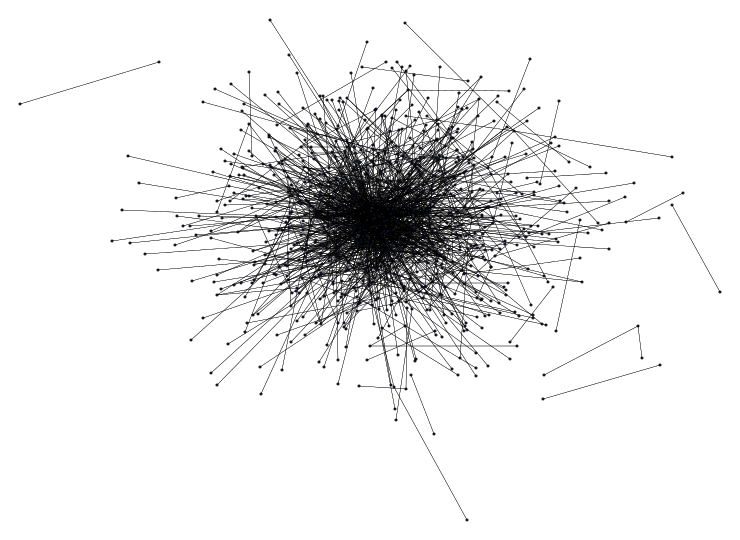

In [11]:
draw_graph(G, show_names=False, node_size=1, edge_width=0.3)

# Inspect the Core

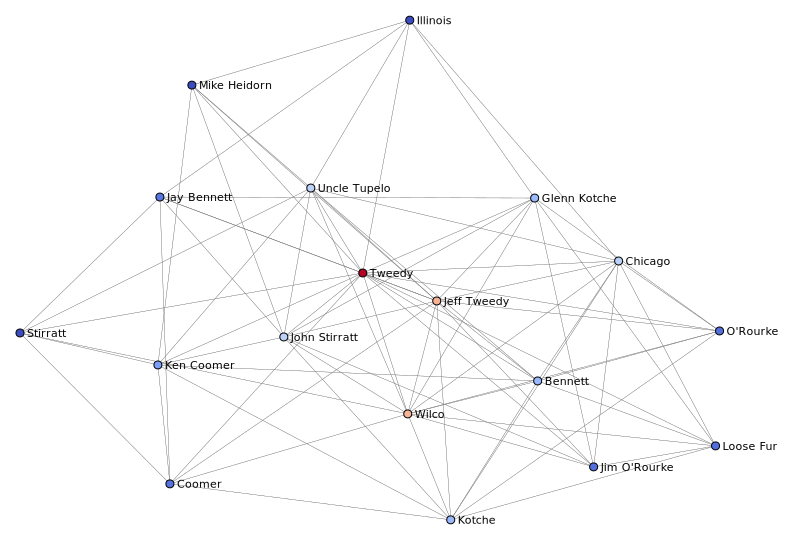

In [13]:
# draw the core

draw_graph(nx.k_core(G, 6), node_size=4, font_size=11, show_names=True, edge_width=0.3)

# Important Nodes

In [14]:
page_rank = nx.pagerank(G)

pr_df = pd.DataFrame().from_dict(page_rank, orient='index')
pr_df.columns = ['page_rank']
pr_df.sort_values('page_rank', ascending=False, inplace=True)
pr_df.head(10)

,page_rank
Wilco,0.034857
Tweedy,0.032642
Uncle Tupelo,0.021789
Chicago,0.011722
Jeff Tweedy,0.010664
Glenn Kotche,0.008173
Street-Level Studio,0.007181
John Stirratt,0.006830
Bragg,0.005687
Mike Heidorn,0.005629


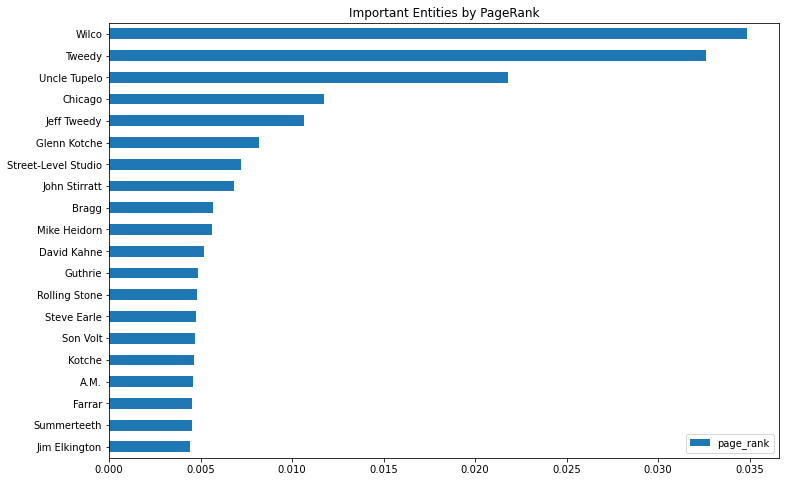

In [15]:
title = 'Important Entities by PageRank'

pr_df.head(20).plot.barh(figsize=(12,8), title=title).invert_yaxis()

In [16]:
betw_cent = nx.betweenness_centrality(G)

betw_cent_df = pd.DataFrame().from_dict(betw_cent, orient='index')
betw_cent_df.columns = ['betweenness_centrality']
betw_cent_df.sort_values('betweenness_centrality', ascending=False, inplace=True)
betw_cent_df.head(10)

,betweenness_centrality
Wilco,0.294453
Tweedy,0.250163
Uncle Tupelo,0.107156
Jeff Tweedy,0.063831
Chicago,0.052534
Glenn Kotche,0.037989
Glenn,0.036210
Sky Blue Sky,0.027553
John Stirratt,0.025864
Coomer,0.025368


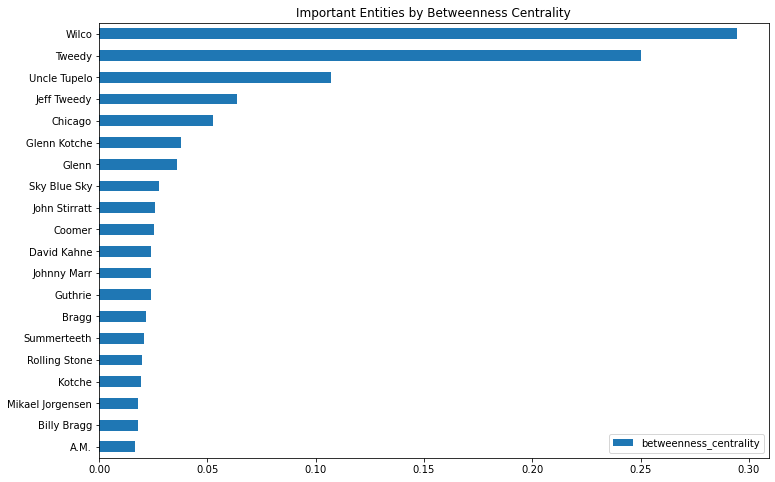

In [17]:
title = 'Important Entities by Betweenness Centrality'

betw_cent_df.head(20).plot.barh(figsize=(12,8), title=title).invert_yaxis()

# So Much More

There's so much more we can do. Look through previous days and think about some of our options. For instance, we might want to understand the shortest path between certain entities, or we might want to look at the communities that are part of this network. This is a completely different kind of network, as this was built entirely off of text, using Machine Learning, using Named Entity Recognition. This is covered in my book. Today's code came from my book's Github.

Also, remember, this is just one field, the 'content' field. We can also create networks using websites as we have the 'web_links' data. There are multiple different networks that can be built using this data.

In [18]:
net_df = nx.to_pandas_edgelist(G)
net_df.head()

,source,target
0,Jeff Tweedy,Wilco
1,Jeff Tweedy,Tweedy
2,Jeff Tweedy,Uncle Tupelo
3,Jeff Tweedy,Reprise Records
4,Jeff Tweedy,Warner Bros


In [19]:
outfile = r'data/wilco_content_edgelist.csv'

net_df.to_csv(outfile, index=False)


In [20]:
nx.info(G)

'Graph with 914 nodes and 1297 edges'